<center>

# **📘 Patent Classification - Task 2**



</center>

Building on the previous experiments with traditional feature-based methods (e.g., TF-IDF + Logistic Regression), which showed strong performance given their simplicity, we now turn to contextual language models—specifically BERT. While TF-IDF proved effective for structured patent text, it lacks the capacity to model word meaning in context. BERT, by contrast, is designed to capture rich semantic and syntactic dependencies, which may be especially valuable for domain-specific and complex texts like patents.

### **Outline**
---



1. [🤖 BERT Model with Limited Data (32 examples)](#bert-limited-data)  
2. [🧪 Dataset Augmentation (No LLMs)](#dataset-augmentation)
3. [🧠 Zero-Shot Learning with LLM](#zero-shot-llm)  
4. [📝 Data Generation with LLM](#data-generation-llm)
5. [🚀 Optimal Technique Application](#optimal-technique)


In [1]:
from utils import Metrics
from datasets import load_dataset, DatasetDict
from datasets import Dataset
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import evaluate, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, random, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style("darkgrid")
#set palette to Spectral
sns.set_palette("Spectral")

In [2]:
dataset = load_dataset("ccdv/patent-classification", "patent")

# **1. Bert Model with Limited Data**
---

This section explores a **few-shot learning setup** where we fine-tune a pre-trained BERT model using only **32 labeled patent**.

The goal is to assess how well BERT can generalize with minimal supervision by leveraging its strong language understanding from pretraining.

**Objective**:
- Perform few-shot fine-tuning of BERT on 32 labeled examples
- Evaluate model performance on a separate validation/test set
- Identify limitations and learning patterns from limited data

| Aspect              | Detail                           |
|---------------------|----------------------------------|
| Model               | BERT (e.g., `distilbert-base-uncased`) |
| Learning Type       | Few-Shot Fine-Tuning             |
| Training Size       | 32 examples total                |
| Task                | Multi-class classification (9)   |
| Evaluation Metric   | Macro F1               |


## **Model checkout**

In this step, we define key hyperparameters and select the pre-trained BERT checkpoint.  
We also set a random seed to ensure reproducibility across runs.

In [3]:
model_ckpt   = "distilbert/distilbert-base-uncased" #'FacebookAI/roberta-base' 

num_labels   = len(set(dataset['train']['label']))
max_length   = 256#128   # truncate / pad length                
batch_size   = 64
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)

## **Tokenizer – Preprocessing**

To prepare the patent texts for BERT, we convert raw text into a format the model can understand using **WordPiece tokenization**.

BERT breaks unfamiliar or complex words into subword units. This is especially useful for technical terms in patents.

### Steps:

1. **Tokenization**: Split text into subword tokens using BERT’s tokenizer.
2. **Special Tokens**: Add `[CLS]` at the beginning (used for classification) and `[SEP]` at the end (to separate segments).
3. **Token to ID Conversion**: Map tokens to numerical IDs from BERT’s vocabulary.
4. **Padding & Truncation**: Ensure all inputs are the same length (via `max_length`), truncating longer texts and padding shorter ones.

We apply this using the `map()` function, converting the dataset into PyTorch-friendly tensors:

In [4]:
tok = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(batch):
    return tok(batch["text"], padding="max_length", truncation=True, max_length=max_length)

dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## **Sample 32 Patent Texts**

Although the original dataset has an **imbalanced class distribution**, we select a sample of **32 examples with a roughly balanced representation across classes**.

This is important because in a **few-shot learning** setting, random sampling would likely favor majority classes, leading the model to overfit and consistently predict those categories.  
By ensuring that all (or most) classes are represented, we give the model a fairer chance to learn basic patterns for each category, even with very limited data.

> Note: In cases where some classes have fewer than the desired number of examples, we sample as many as available.


In [5]:
sample_training = dataset["train"].shuffle(seed=seed)

#from sample_training keep 4 samples per class
def keep_n_per_class(dataset, n):
    df = dataset.to_pandas()
    df = df.groupby('labels').apply(lambda x: x.sample(n=min(len(x), n), random_state=seed)).reset_index(drop=True)
    df = df.sample(32, random_state=seed)  # Shuffle the final dataset to ensure randomness
    return DatasetDict({"train": Dataset.from_pandas(df)})

sample_training = keep_n_per_class(sample_training, 4)

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_78279/2278813389.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('labels').apply(lambda x: x.sample(n=min(len(x), n), random_state=seed)).reset_index(drop=True)


We will use <code>AutoModelForSequenceClassification</code> that is a HF library that automatically chosses the correct architecture  for our model checkpoint, adds classification taks head and handles token types, attention mask and output correcly.

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Metric functions**

In [7]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="weighted", zero_division=0)
    rec  = metric_recall.compute(predictions=preds, references=labels, average="weighted", zero_division=0)

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"]
    }

## **Configure TrainingArguments**

The key arguments to be tuned are <code>learning_rate</code>, <code>num_train_epochs</code>

In [8]:
args = TrainingArguments(
    output_dir          = "./final_project_cls",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "steps",
    logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 20,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = False, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

## **Initialize Trainer**

This class from HF handles the running of the training loops, evaluatin the model, saving the logs and checkpoints and applying callbacks like early stopping.

In [9]:
trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = sample_training['train'],
    eval_dataset    = dataset["validation"].shuffle(seed=seed),
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [10]:
train_output = trainer.train()

/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,No log,2.201459,0.098800,0.092281,0.098800
2,No log,2.196458,0.122800,0.220271,0.122800
3,No log,2.191426,0.139200,0.243557,0.139200
4,No log,2.186117,0.166600,0.260210,0.166600
5,No log,2.179833,0.214000,0.301256,0.214000
6,No log,2.173501,0.250400,0.399742,0.250400
7,No log,2.167433,0.273200,0.385505,0.273200
8,No log,2.161712,0.281800,0.392448,0.281800
9,No log,2.156046,0.286200,0.376340,0.286200
10,No log,2.150610,0.286000,0.450449,0.286000


/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683:

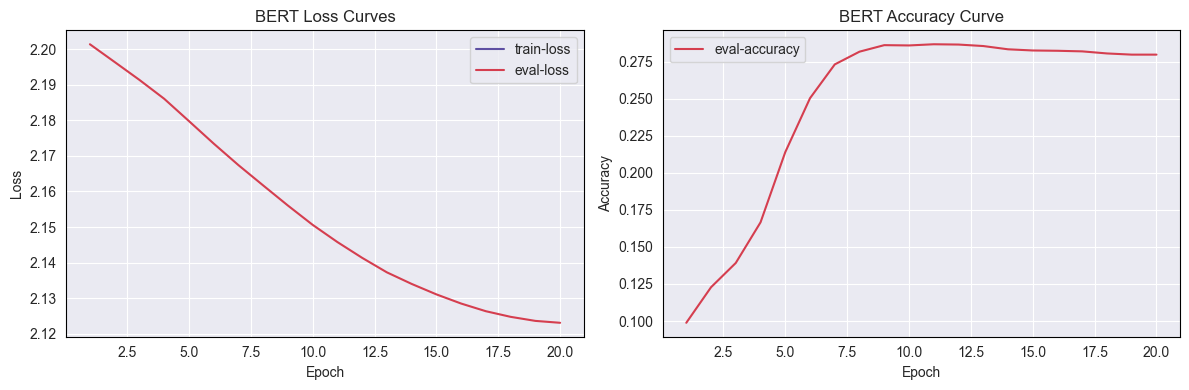

In [11]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

def plot_bert_metrics(steps_train, train_loss, steps_eval, eval_loss, eval_acc, 
                      title_prefix="BERT", figsize=(12,4),
                      train_loss_color='#5e4fa2', eval_loss_color='#d53e4f', eval_acc_color='#d53e4f'):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Left subplot: Loss curves
    axes[0].plot(steps_train, train_loss, label="train-loss", color=train_loss_color)
    axes[0].plot(steps_eval, eval_loss, label="eval-loss", color=eval_loss_color)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].set_title(f"{title_prefix} Loss Curves")
    for spine in axes[0].spines.values():
        spine.set_color('black')

    # Right subplot: Accuracy curve
    axes[1].plot(steps_eval, eval_acc, label="eval-accuracy", color=eval_acc_color)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].set_title(f"{title_prefix} Accuracy Curve")
    for spine in axes[1].spines.values():
        spine.set_color('black')

    plt.tight_layout()

plot_bert_metrics(steps_train, train_loss, steps_eval, eval_loss, eval_acc, title_prefix="BERT")

In [12]:
test_metrics = trainer.evaluate(dataset["test"])
print(test_metrics)

/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.1186344623565674, 'eval_accuracy': 0.2882, 'eval_precision': 0.30167922561085314, 'eval_recall': 0.2882, 'eval_runtime': 60.8773, 'eval_samples_per_second': 82.132, 'eval_steps_per_second': 1.298, 'epoch': 20.0}


In [13]:
predictions = trainer.predict(dataset["test"])

/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


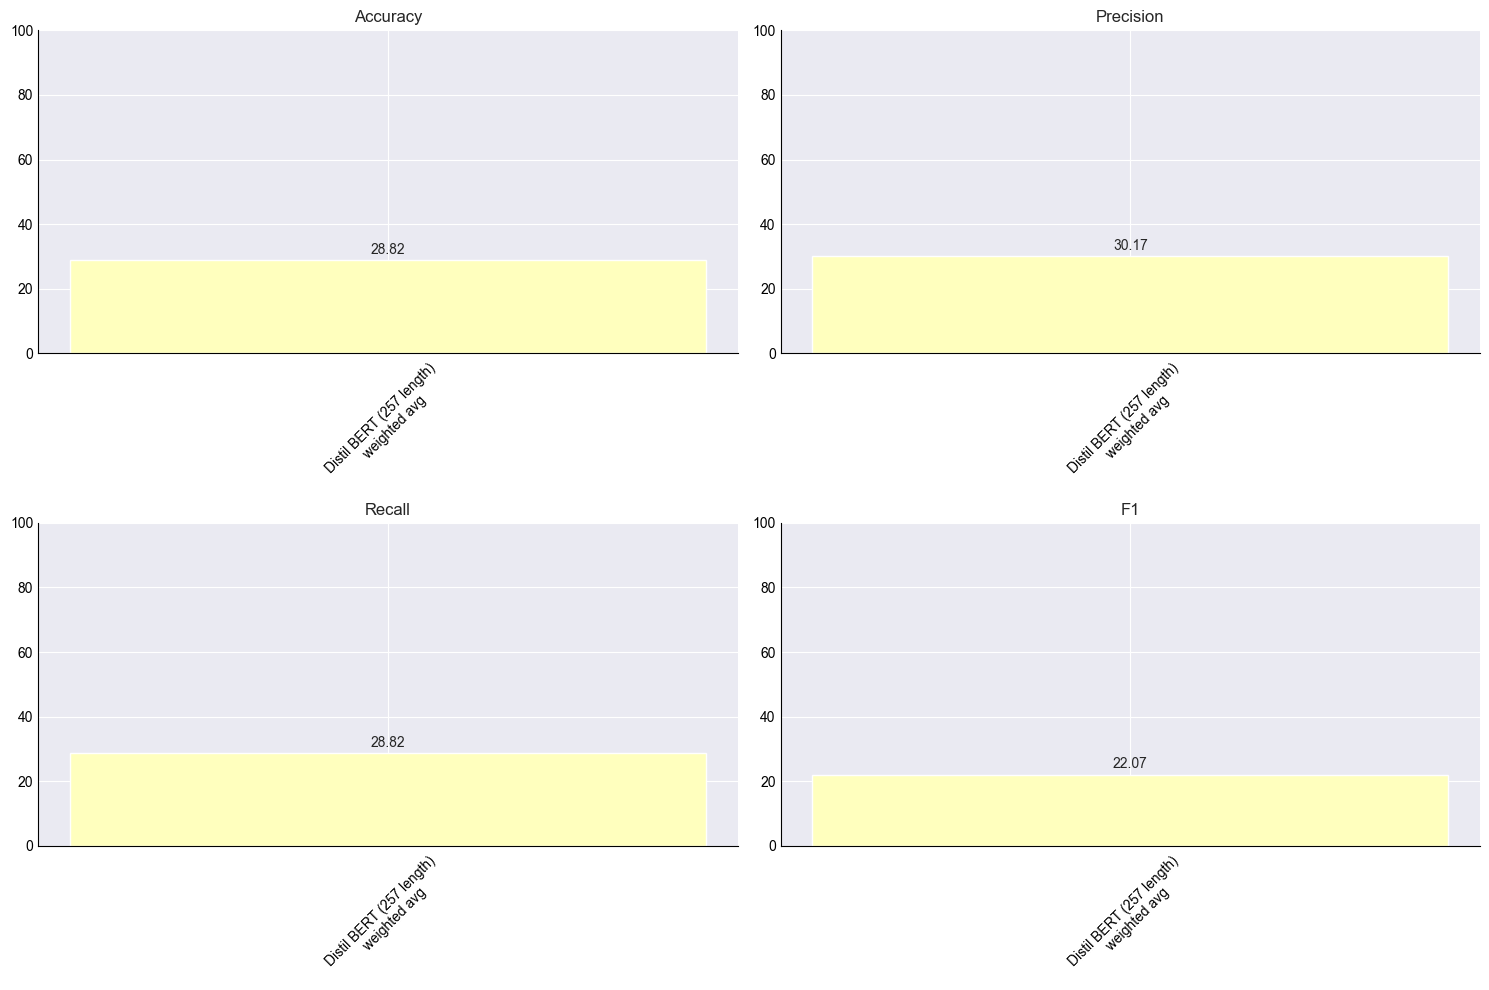

In [27]:
results = Metrics()
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
results.run(y_true, y_pred, 'Distil BERT (257 length) \n weighted avg', average='weighted')
results.plot()

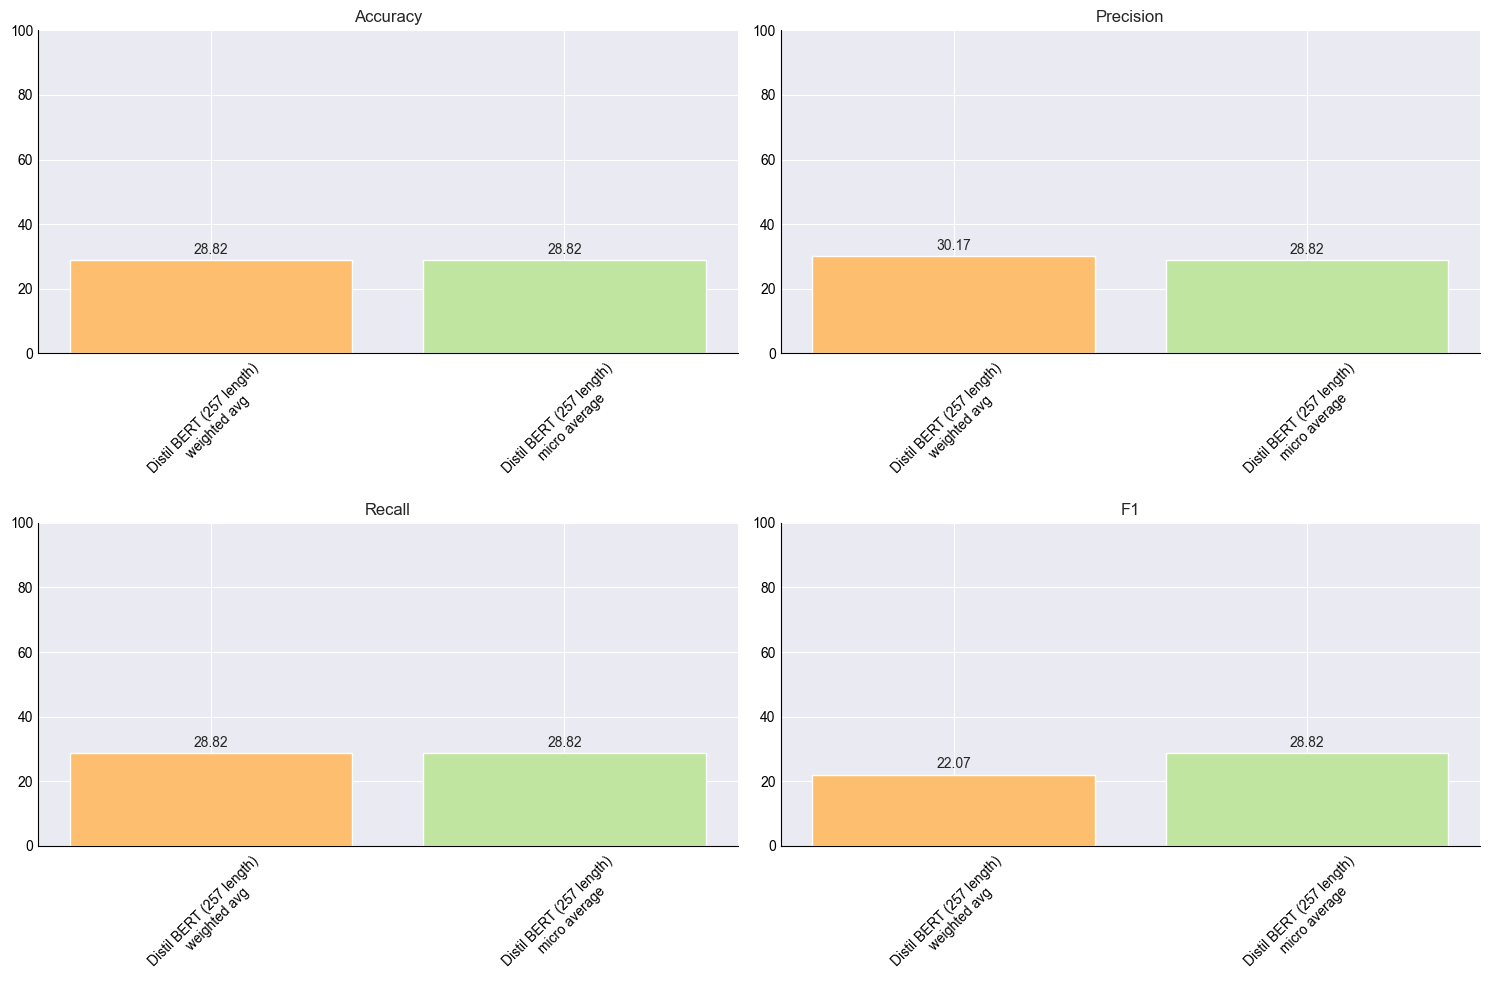

In [28]:
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
results.run(y_true, y_pred, 'Distil BERT (257 length) \n micro average', average='micro')
results.plot()

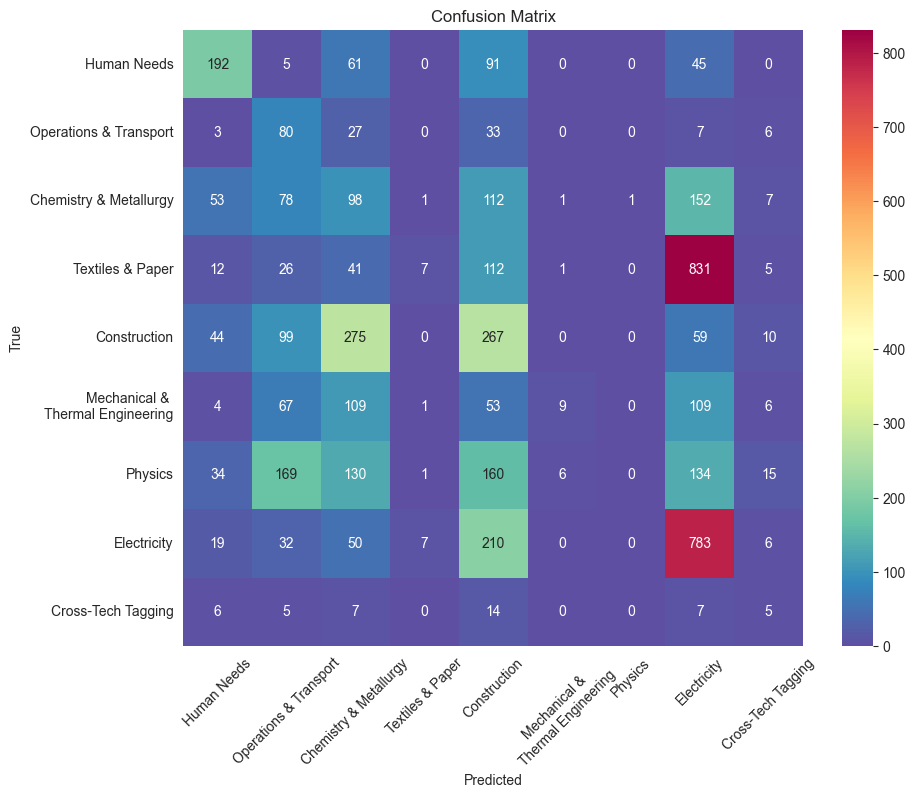

In [26]:
label_map = {
    '0': "Human Needs",
    '1': "Operations & Transport",
    '2': "Chemistry & Metallurgy",
    '3': "Textiles & Paper",
    '4': "Construction",
    '5': "Mechanical & \nThermal Engineering",
    '6': "Physics",
    '7': "Electricity",
    '8': "Cross-Tech Tagging"
}

#plot confussion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral_r',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #rotate x labels
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

label_map_int = {int(k): v for k, v in label_map.items()}

# convert predictions and true labels
y_test_true_named = [label_map_int[label] for label in y_true]
y_test_pred_named = [label_map_int[label] for label in y_pred]
# Plot confusion matrix
conf_matrix = plot_confusion_matrix(y_test_true_named, y_test_pred_named, classes=list(label_map_int.values()))

# **2. Dataset Augmentation**
---

To address the data scarcity, this section explores automated augmentation techniques that do not rely on large language models (LLMs). Techniques like synonym replacement, back-translation, or TF-IDF-based sentence swaps are considered.

Objective:

- Increase the size and diversity of labeled data without using LLMs

- Train BERT on the augmented set

- Compare metrics to baseline (32-label setup)

Augmentation Examples:

| Technique           | Description                            |
| ------------------- | -------------------------------------- |
| Synonym Replacement | Replace words using WordNet            |
| Back Translation    | Translate to another language and back |
| Sentence Shuffling  | Rearrange sentence order               |



In [39]:
dataset = load_dataset("ccdv/patent-classification", "patent")

sample_training = dataset["train"].shuffle(seed=seed)
from datasets import Dataset
#from sample_training keep 4 samples per class
def keep_n_per_class(dataset, n):
    df = dataset.to_pandas()
    df = df.groupby('label').apply(lambda x: x.sample(n=min(len(x), n), random_state=seed)).reset_index(drop=True)
    df = df.sample(32, random_state=seed)  # Shuffle the final dataset to ensure randomness
    return DatasetDict({"train": Dataset.from_pandas(df)})

sample_training = keep_n_per_class(sample_training, 4)

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_78279/1461820078.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label').apply(lambda x: x.sample(n=min(len(x), n), random_state=seed)).reset_index(drop=True)


In [40]:
sample_training['train']

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 32
})

## **Setence Shuffling**
---

In [41]:
import random
from collections import defaultdict
from datasets import DatasetDict, Dataset
import pandas as pd
#import nltk

#nltk.download("punkt")
#from nltk.tokenize import sent_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")

def sent_tokenize(text):
    return [sent.text for sent in nlp(text).sents]

def oversample_by_sentence_shuffling(dataset, n_samples_per_class, text_col="text", label_col="labels", seed=42):
    random.seed(seed)
    df = dataset.to_pandas()
    
    # Count current class distribution
    class_groups = df.groupby(label_col)
    augmented_rows = []

    for label, group in class_groups:
        current_count = len(group)
        needed = n_samples_per_class - current_count

        # If already enough samples, keep as-is
        if needed <= 0:
            continue

        # Pick samples to augment (with replacement if needed)
        samples_to_augment = group.sample(n=needed, replace=True, random_state=seed)

        for _, row in samples_to_augment.iterrows():
            original_text = row[text_col]
            sentences = sent_tokenize(original_text)
            if len(sentences) > 1:
                random.shuffle(sentences)
                new_text = " ".join(sentences)
            else:
                new_text = original_text  # can't shuffle single sentence

            augmented_rows.append({text_col: new_text, label_col: label})

    # Build augmented DataFrame
    df_augmented = pd.DataFrame(augmented_rows)

    # Combine original + augmented
    df_combined = pd.concat([df, df_augmented], ignore_index=True)

    # Shuffle final dataset
    df_combined = df_combined.sample(frac=1, random_state=seed).reset_index(drop=True)

    return DatasetDict({
        "train": Dataset.from_pandas(df_combined)
    })

In [42]:
oversampled_dataset = oversample_by_sentence_shuffling(
    sample_training["train"], 
    n_samples_per_class=10, 
    text_col="text", 
    label_col="label", 
    seed=seed
)
oversampled_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 90
    })
})

In [43]:
tok = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(batch):
    return tok(batch["text"], padding="max_length", truncation=True, max_length=max_length)

dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch")

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [44]:
oversampled_dataset = oversampled_dataset.map(tokenize, batched=True, remove_columns=["text"])
oversampled_dataset = oversampled_dataset.rename_column("label", "labels")
oversampled_dataset.set_format("torch")

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

In [45]:
args = TrainingArguments(
    output_dir          = "./final_project_cls",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "steps",
    logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 10,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = False, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

In [46]:
trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = oversampled_dataset['train'],
    eval_dataset    = dataset["validation"].shuffle(seed=seed),  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [47]:
train_output = trainer.train()

/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,No log,2.112648,0.274800,0.388361,0.274800
2,No log,2.102417,0.283400,0.400495,0.283400
3,No log,2.091856,0.295000,0.412949,0.295000
4,No log,2.085052,0.301800,0.401974,0.301800
5,No log,2.079186,0.308600,0.401818,0.308600
6,No log,2.072870,0.313600,0.401892,0.313600
7,No log,2.067931,0.316400,0.399434,0.316400
8,No log,2.063591,0.318600,0.397572,0.318600
9,No log,2.060351,0.321400,0.396271,0.321400
10,No log,2.058577,0.323000,0.395155,0.323000


/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683:

In [48]:
predictions = trainer.predict(dataset["test"])

/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


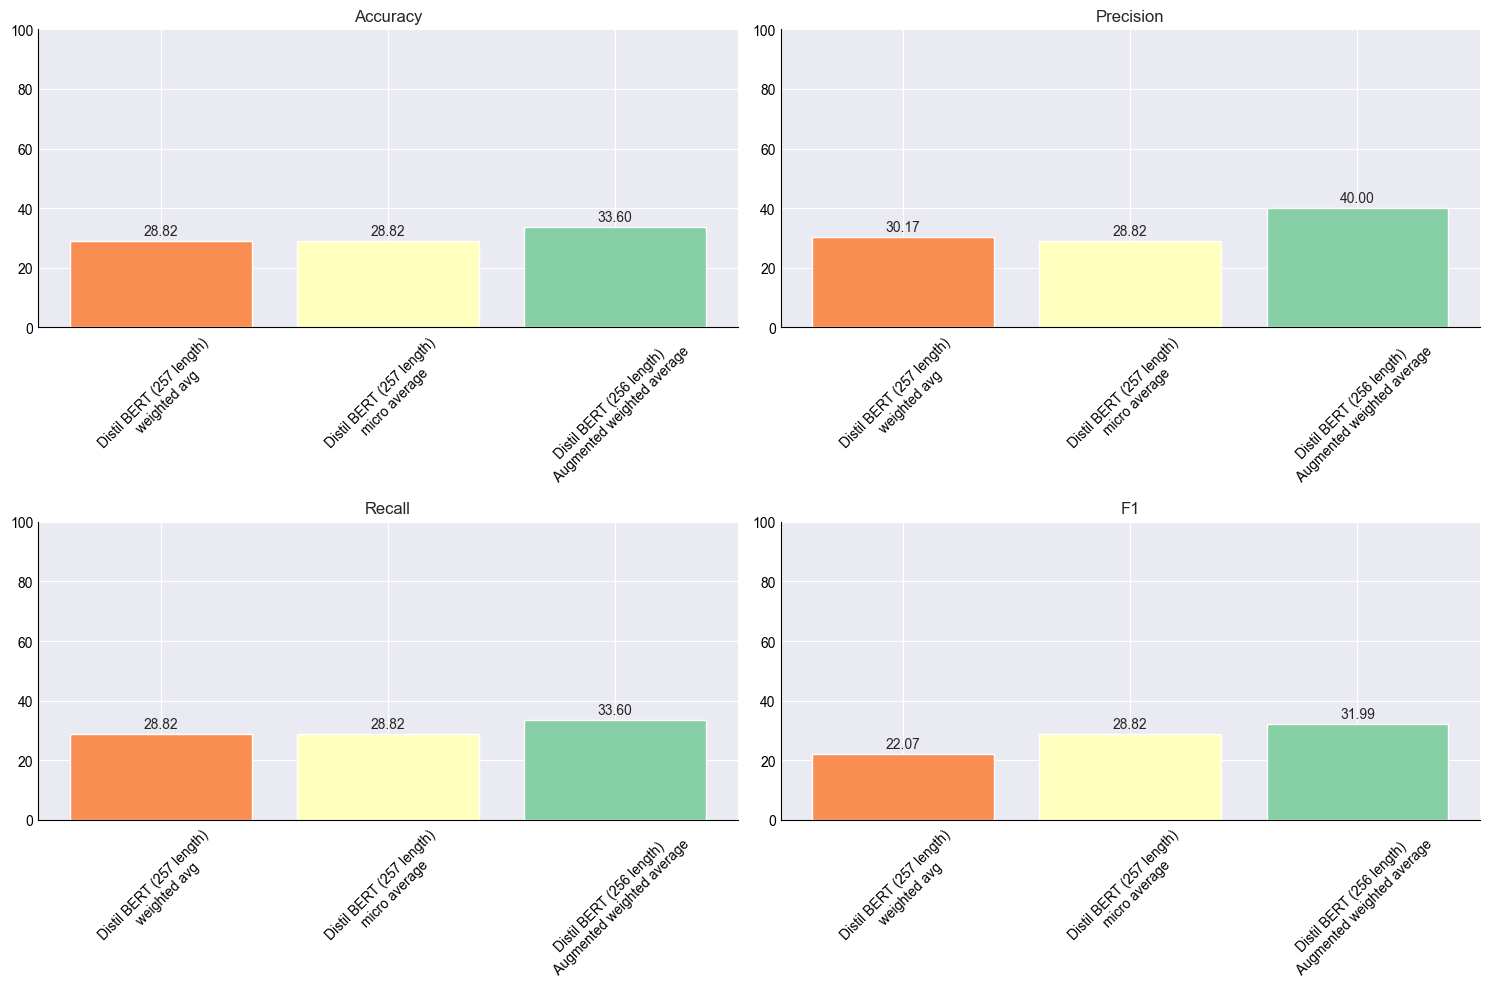

In [49]:
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
results.run(y_true, y_pred, 'Distil BERT (256 length)\n Augmented weighted average', average='weighted')
results.plot()

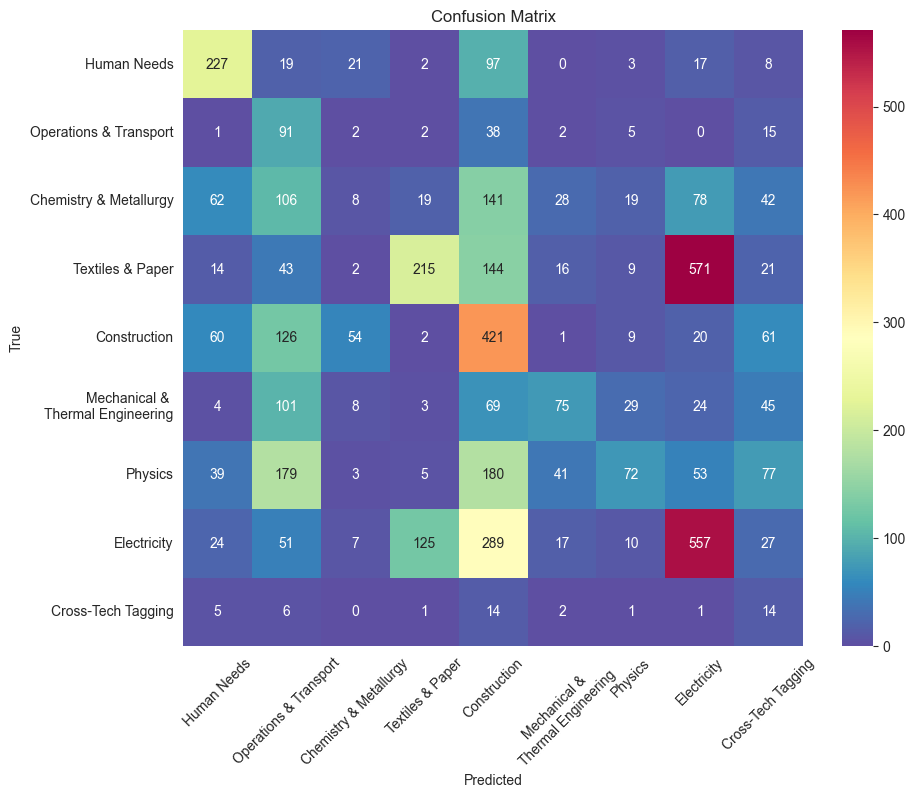

In [50]:
label_map = {
    '0': "Human Needs",
    '1': "Operations & Transport",
    '2': "Chemistry & Metallurgy",
    '3': "Textiles & Paper",
    '4': "Construction",
    '5': "Mechanical & \nThermal Engineering",
    '6': "Physics",
    '7': "Electricity",
    '8': "Cross-Tech Tagging"
}

#plot confussion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral_r',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #rotate x labels
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

label_map_int = {int(k): v for k, v in label_map.items()}

# convert predictions and true labels
y_test_true_named = [label_map_int[label] for label in y_true]
y_test_pred_named = [label_map_int[label] for label in y_pred]
# Plot confusion matrix
conf_matrix = plot_confusion_matrix(y_test_true_named, y_test_pred_named, classes=list(label_map_int.values()))

# **3. Zero-Shot Learning with LLM**
---

Here, we evaluate how well an LLM can classify patents without fine-tuning, relying on its general knowledge and a well-crafted prompt. This approach is useful for understanding model capability in zero-resource scenarios.

Objective:

- Use an LLM (e.g., ChatGPT, Claude) to predict categories from raw text

- Measure classification performance and compare to fine-tuned BERT

| Setup      | Value                   |
| ---------- | ----------------------- |
| Labels     | Provided via prompt     |
| Model      | ChatGPT / Claude / etc. |
| Evaluation | Zero-shot performance   |


# **4. Data Generation with LLM**
---

This section leverages an LLM to generate new labeled patent-like texts for underrepresented or all categories. These synthetic samples are added to the original 32 examples to retrain BERT and assess performance improvements.

Objective:

- Use an LLM to generate realistic labeled data

- Retrain BERT with synthetic + original data

- Evaluate performance gains

| Input | Few real samples (32) |
| Output | LLM-generated labeled texts |
| Goal | Improve classifier accuracy & robustness |

# **5. Optimal Technique Application**
---

Based on all prior experiments, this section identifies the most effective data strategy—augmentation, zero-shot inference, or LLM-generated data—and applies it at scale. The final BERT model is evaluated with improved input, and further improvements are proposed.

Objective:

- Combine or refine top-performing techniques

- Re-train and evaluate final BERT model

- Suggest next steps (e.g., semi-supervised learning, better prompts)

| Evaluated Strategies  | Performance Impact |
| --------------------- | ------------------ |
| 32-Example Baseline   | 🔽 Low             |
| Augmentation (No LLM) | ⚠️ Variable        |
| LLM-Generated Samples | ✅ Boosted Accuracy |
| Zero-Shot LLM         | ➖ Useful baseline  |

